In [1]:
# !pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### This project is made using the playlist :

##### https://youtube.com/playlist?list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH&si=6b0qNPymO5H6a-FD

##### And the paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

###### This is solely the making of Yug Agarwal, 22b0651



In [3]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt # needed during plt.imshow

In [4]:
# Import tensorflow dependencies - using Functional API, instead of Sequential
from tensorflow.keras.models import Model # takes input and gives ouput
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [5]:
# Avoid out of memeory error by setting GPU memory consumption growth
# To be used only when ypur machine has a GPU and tensorflow is used
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
  # passing all the gpus one by one that we will be using and setting their
  # memory growth to some finite value, True means for setting the limit

In [7]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Week_4')
# and create a new folder called 'data'
# then in this create three sub folders with the names
# 'positive' 'negative' and 'anchor', if you guys want to keep everything in
# one folder in gdrive, also neglect the quote marks ''

In [8]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Run these 3 lines only once in a runtime
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [10]:
# https://vis-www.cs.umass.edu/lfw/#download
# Uncompress tgz file in the wild dataset

# This is the command to uncompress --> !tar -xf lfw.tgz

In [11]:
# Move LFW images to the following repositories data/negative

# This following code is supposed to be run only once for extracting from lfw
# the different images into ANC and NEG
# Hence run it only once

# for directory in os.listdir('lfw'):
#   for file in os.listdir(os.path.join('lfw', directory)):
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)


In [12]:
# List available cameras
# def list_cameras():
#     index = 0
#     arr = []
#     i = 10
#     while i > 0:
#         cap = cv2.VideoCapture(index)
#         if cap.read()[0]:
#             arr.append(index)
#             cap.release()
#         index += 1
#         i -= 1
#     return arr

# print("Available cameras:", list_cameras())

In [13]:
# Import uuid library to unique image names
import uuid
uuid.uuid1()
# this code here generate a unique number each time you run it
# and this we will be going to put as the name of the different images

UUID('394bfecc-4ea7-11ef-9273-0242ac1c000c')

#### This code was written on my macbook whose cameras were not recognised hence I used my home's Windows PC and got the positive and anchor image dataset hence I am commenting this whole code now

In [14]:
# # Establish a connection to a webcam
# cap = cv2.VideoCapture(0)
# while cap.isOpened(): # goes through all the frames recvd from the webcam
#   ret, frame = cap.read()
#   # Cut down frame to 250x250 px
#   frame = frame[120:120+250, 200:200+250, :]

#   # collect anchors
#   if cv2.waitKey(1) & 0XFF == ord('a'):
#     # creating the unique file path
#     imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#     cv2.imwrite(imgname, frame)

#   # collect positives
#   if cv2.waitKey(1) & 0XFF == ord('p'):
#     imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#     cv2.imwrite(imgname, frame)


#   # Show image back to screen
#   cv2.imshow('Image Collection', frame)

#   # Now breaking this task peacefully
#   if cv2.waitKey(1) & 0XFF == ord('q'):
#     # end the webcam window when q is hit on the keyboard
#     break

# cap.release()
# cv2.destroyAllWindows()

In [15]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

# this is taking 300 image data PATHS and not the actual images yet
# The /*.jpg part needs to be set according to your computer, as in how is it
# accessing the images in \\ format or / format

In [16]:
dir_test = anchor.as_numpy_iterator()
# we would be using the .next() function for this dir_test

In [17]:
def preprocess(file_path):
  # read image present on this file path
  byte_img = tf.io.read_file(file_path)
  # Load in the image as an array
  img = tf.io.decode_jpeg(byte_img)
  # Resizing to 100x100 as required by siamese network
  img = tf.image.resize(img, (100,100))
  # scaling so that image array has values between 0 and 1
  img = img/255.0
  return img

In [ ]:
# dataset.map(preprocess)

In [18]:
# Now we need to create the ideal predictions for our model so that it
# can calculate loss and gradients w.r.t this
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
example = samples.next()
example

(b'data/anchor/d59ac865-4cbf-11ef-9d67-9822ef94fd0a.jpg',
 b'data/positive/d08c30a9-4cc0-11ef-ab22-9822ef94fd0a.jpg',
 1.0)

In [21]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*example)

In [23]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [24]:
# getting the training data
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8) # So that we dont bottleneck our NN while training

In [25]:
test_data = data.skip(round(len(data)*0.7))
test_data = data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering

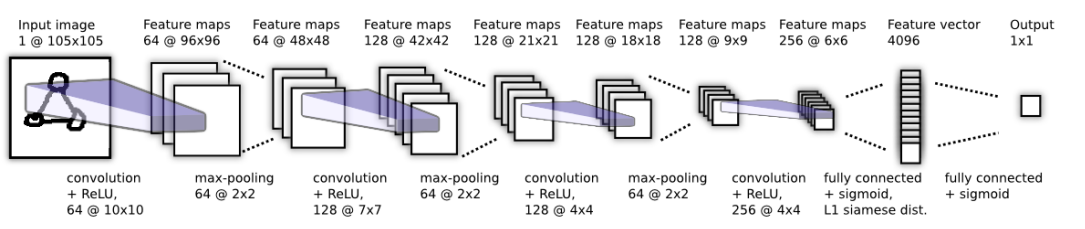

### Building Embedding Layer


In [26]:
def make_embedding():
  inp = Input(shape = (100,100,3), name = 'input_image')
  # first block
  c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

  #Second Block
  c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

  # Third Block
  c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

  # Last convolutional layer
  c4 = Conv2D(256, (4,4), activation = 'relu')(m3)

  # Fully Connected + signmoid
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  # L1 Siamese distance and the output layer will be made in the following
  # sections of code

  return Model(inputs= [inp], outputs= [d1],name= 'embedding')

In [27]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Building Distance Layer


In [28]:
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

### Make Siamese Network


In [29]:
def make_siamese_model():

  # Handling Anchor Input image
  input_image = Input(name = 'input_img', shape=(100,100,3))

  #The image to be tested/check for is passed
  validation_image = Input(name = 'validation_img', shape = (100,100,3))

  #Combining Siamese distance layer
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classification Layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [30]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Training

## Setup loss and optimiser


In [31]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(0.0001)

## Establish Checkpoints


In [32]:
# Directory to save our checkpoints
checkpoint_dir = './training_checkpoints'

# So that all the checkpoints have a sequential ordering where they start with
# ckpt and then go like ckpt0, ckpt1, ckpt2, ckpt3, ...
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# We want to save 2 components- optimizer and
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

## Build train step function

In [37]:
# Put the entire NN in a graph so that it can train in an efficient manner
@tf.function
def train_step(batch):
  # start capturing gradients for automatic differentiaiton
  with tf.GradientTape() as tape:
    # Get the anchor and positive/negative images
    X = batch[:2]
    # Get Label
    y = batch[2]

    # Get network's value
    yhat = siamese_model(X, training= True)
    # Calculate Loss
    loss = binary_cross_loss(y, yhat)
  print(loss)

  # Calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)
  # Calculate Updated weights and apply siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

## Build Training Loop

In [38]:
def train(data, EPOCHS):
  # Loop through epochs
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    # Loop through each batch
    for idx, batch in enumerate(data):
      # Run train step
      train_step(batch)
      progbar.update(idx + 1)

    # Save Checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)


## Train the Model

In [35]:
EPOCHS = 50

In [39]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 14s 200ms/step

 Epoch 2/50
27/27 [==============================] - 4s 157ms/step

 Epoch 3/50
27/27 [==============================] - 4s 159ms/step

 Epoch 4/50
27/27 [==============================] - 4s 159ms/step

 Epoch 5/50
27/27 [==============================] - 4s 159ms/step

 Epoch 6/50
27/27 [==============================] - 4s 159ms/step

 Epoch 7/50
27/27 [==============================] - 4s 159ms/step

 Epoch 8/50
27/27 [==============================] - 4s 159ms/step

 Epoch 9/50
27/27 [==============================] - 4s 154ms/step

 Epoch 10/50
27/27 [==============================] - 4s 148ms/step

 Epoch 11/50
27/27 [==============================] - 4s 153ms/step

 Epoch 12/50
27/27 [==============================] - 4s 149ms/step

 Epoch 13/50
27/27 [=====

# Evaluate Model

In [60]:
# Import metrics calculations
from tensorflow.keras.metrics import Precision, Recall

In [61]:
# Get Batch of Test Data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
# This basically broke down the 3 different things in test_data to the
# respective numpy arrays and the .next is to increment it continuously
# Here the test_data has one anchor image and then a negative or
# positive image and then the desired label that our model shpuld predict

In [62]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 22ms/step


array([[1.2619931e-16],
       [1.0000000e+00],
       [2.6612005e-18],
       [3.6191719e-19],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.2306293e-18],
       [3.5543654e-16],
       [4.3255018e-13],
       [3.1374329e-17],
       [8.5326157e-19],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9955922e-01],
       [1.0000000e+00]], dtype=float32)

In [63]:
# Post processing the results to get classification
[1 if prediction > 0.5 else 0 for prediction in y_hat]
# Read it as "give 1 if y_hat > 0.5 else give 0"
# This will return an araray of 0's and 1's and
# size same as that of the y_hat array

[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]

In [64]:
# Now we define the calculations to be performed to get the metrics
m = Recall()
m.update_state(y_true, y_hat)

# Return the recall value on one test sample
# and the closer this value (and/or Precision value) to 1 => the better
m.result().numpy()

1.0

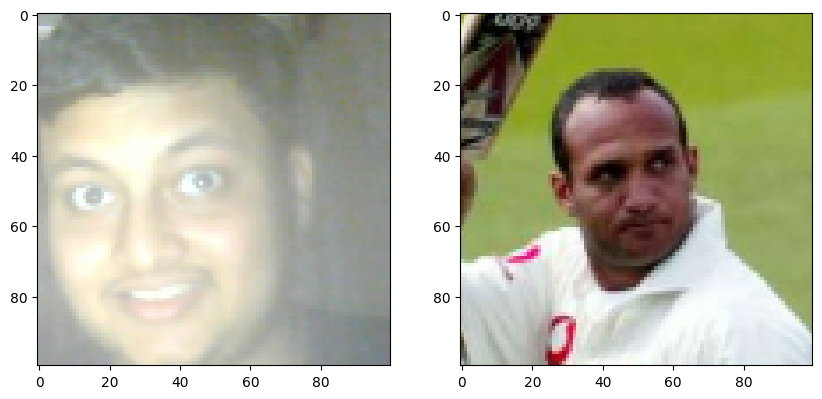

In [73]:
# set plot size
plt.figure(figsize = (10,8))

# Set first subplot, the plt.subplot() takes in 3 arguments - no.of rows
# no.of colomns and the index of the image (1-base)
plt.subplot(1,2,1)
plt.imshow(test_input[3]) # shows the fourth test_data input
                          # This is the anchor

# Set the second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3]) # shows the 4th image in test_data which the model had
                        # to recognize as 1 or 0, given the image in subplot-1
# This is the negative or positive image, You can see 2 blocks above and
# check for the 10 inputs that the model is correctly marking 1 or 0
# basically this code block is for visual/manual checking and correlating
# whether the 1 and 0 were correct or not.


plt.show()
# After this step is just saving our model